<a href="https://www.kaggle.com/code/kusumakar/loan-predictions-92-accuracy?scriptVersionId=199935890" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
df=pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")

In [3]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


### Steps we will perform in this notebook to come to predictions
1) Exploratory Data Analysis

        i) Check Numerical and Categorical Columns
        ii) Check the outliers and discard them.
        iii) Check for null values and impute / drop them.
        iv) Check for correlation between the numerical features.
        v) Check which features impact our target variable

In [4]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [5]:
df.dtypes

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object

In [6]:
## Numerical Columns 
numerical = list(df.select_dtypes(include=['int64','float64']).columns)
categorical = list(df.select_dtypes(include=['object']).columns)

In [7]:
print("Numerical Columns ",numerical)
print("Categorical Columns",categorical)

Numerical Columns  ['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']
Categorical Columns ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


## Check null values

In [8]:
df.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

### No null values present

### OUTLIERS

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

    

In [10]:
print(numerical)

['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']


<Axes: >

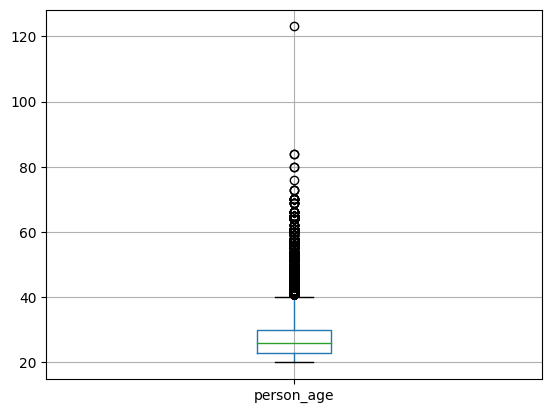

In [11]:
df[['person_age']].boxplot()

## Age column has outliers. Let's remove such outliers.

I will create a function that will take a column name and will return dataframe after removing the outliers. I will use inter-quartile range to remove the outliers

In [12]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out
df=remove_outlier(df,'person_age')

<Axes: >

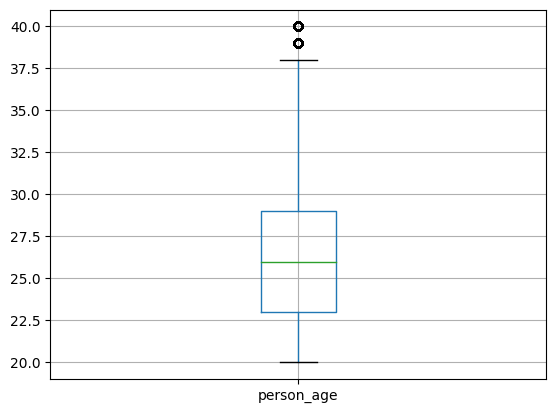

In [13]:
df[['person_age']].boxplot()

<Axes: >

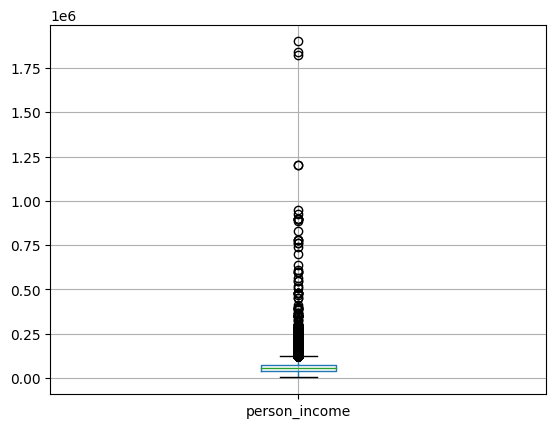

In [14]:
df[['person_income']].boxplot()

This column has outliers too. We will remove such outliers

In [15]:
df=remove_outlier(df,'person_income')

<Axes: >

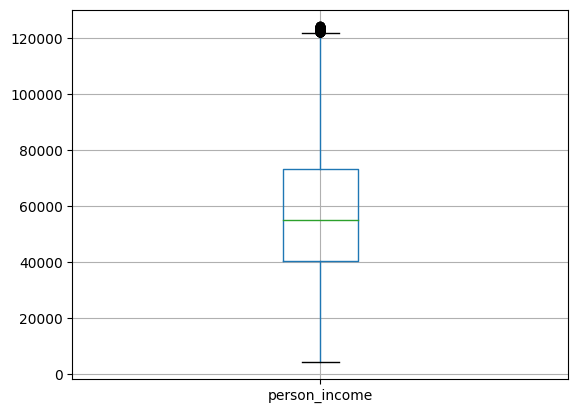

In [16]:
df[['person_income']].boxplot()

Outliers in 'person_emp_length'

<Axes: >

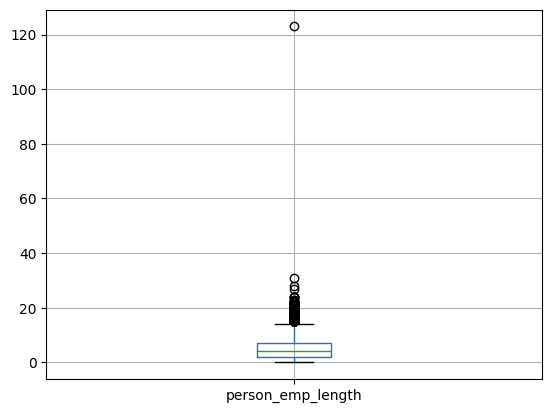

In [17]:
df[['person_emp_length']].boxplot()

In [18]:
df=remove_outlier(df,'person_emp_length')

<Axes: >

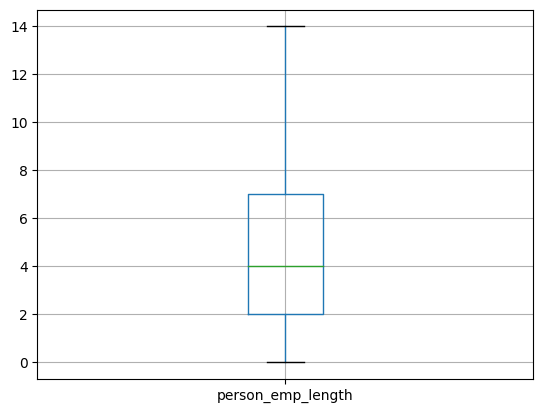

In [19]:
df[['person_emp_length']].boxplot()

<Axes: >

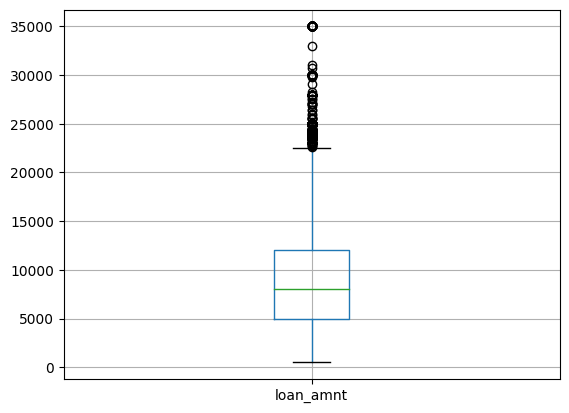

In [20]:
df[['loan_amnt']].boxplot()

In [21]:
df=remove_outlier(df,'loan_amnt')

<Axes: >

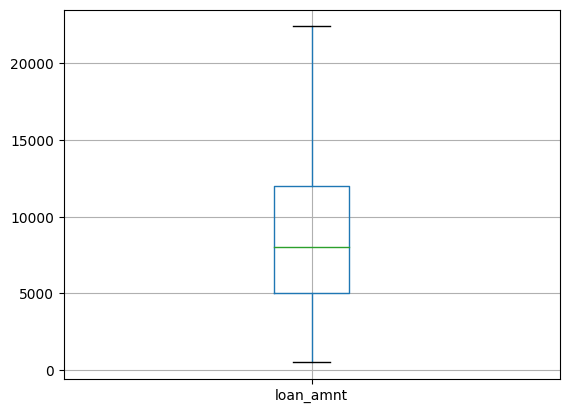

In [22]:
df[['loan_amnt']].boxplot()

<Axes: >

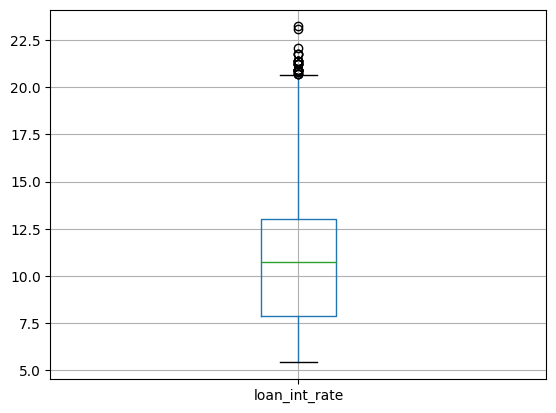

In [23]:
df[['loan_int_rate']].boxplot()

In [24]:
df=remove_outlier(df,'loan_int_rate')

<Axes: >

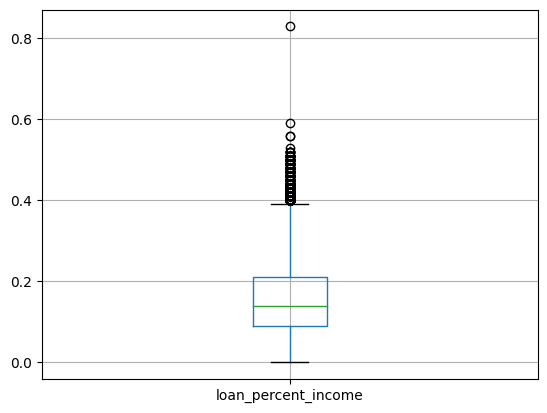

In [25]:
df[['loan_percent_income']].boxplot()

In [26]:
df=remove_outlier(df,'loan_percent_income')

<Axes: >

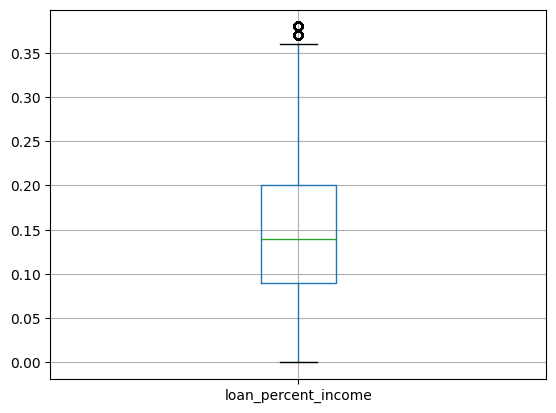

In [27]:
df[['loan_percent_income']].boxplot()

<Axes: >

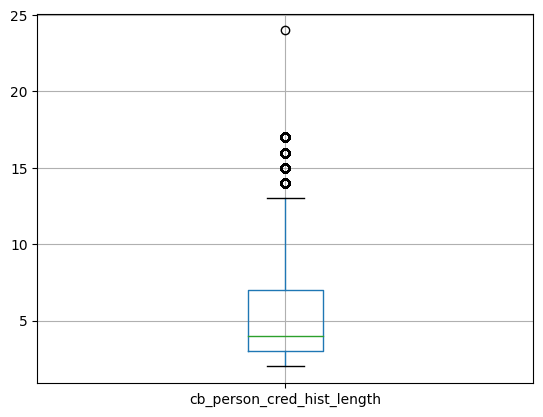

In [28]:
df[['cb_person_cred_hist_length']].boxplot()

In [29]:
df=remove_outlier(df,'cb_person_cred_hist_length')

<Axes: >

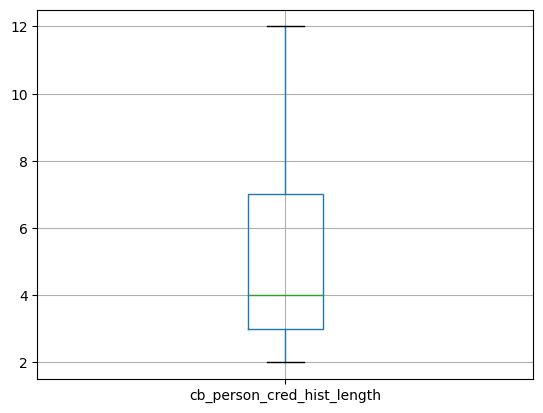

In [30]:
df[['cb_person_cred_hist_length']].boxplot()

## Let us find the correlation between Features

In [31]:
print(numerical)

['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='person_age', ylabel='Count'>

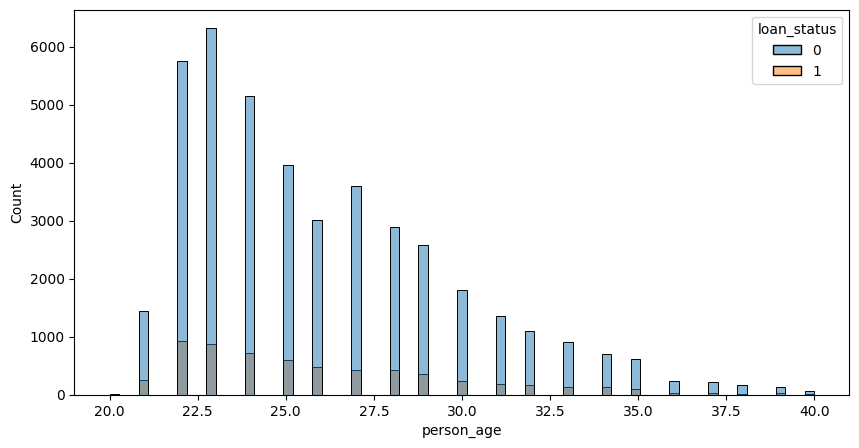

In [32]:
plt.figure(figsize=(10,5))
sns.histplot(x='person_age',hue='loan_status',data=df)

### Person Age doesn't impact loan approval and denial based on the figure above

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='person_income', ylabel='Count'>

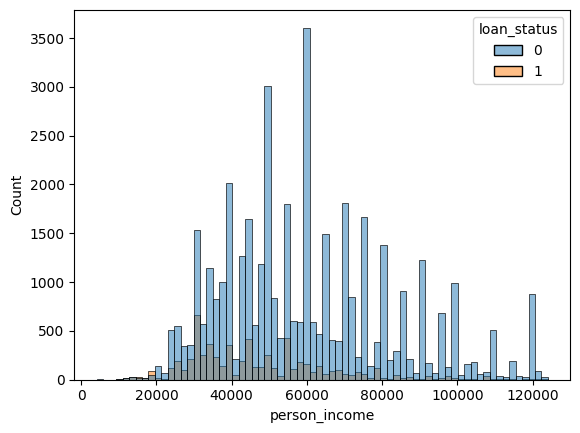

In [33]:
sns.histplot(x='person_income',hue='loan_status',data=df)

## As the income increases, loan approval probability increases

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='person_emp_length', ylabel='Count'>

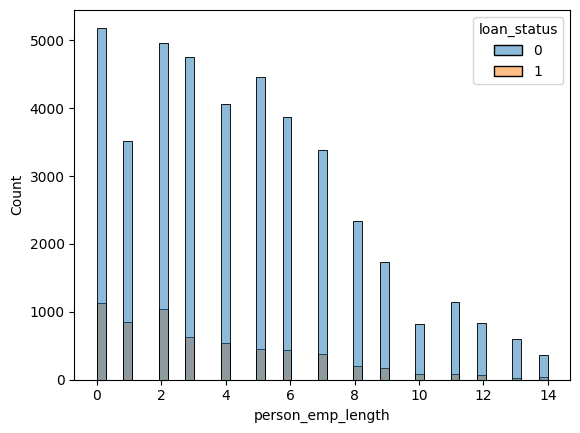

In [34]:

sns.histplot(x='person_emp_length',hue='loan_status',data=df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='loan_amnt', ylabel='Count'>

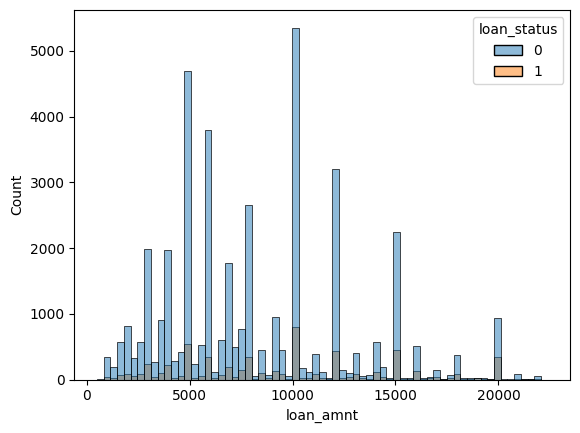

In [35]:

sns.histplot(x='loan_amnt',hue='loan_status',data=df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='loan_percent_income', ylabel='Count'>

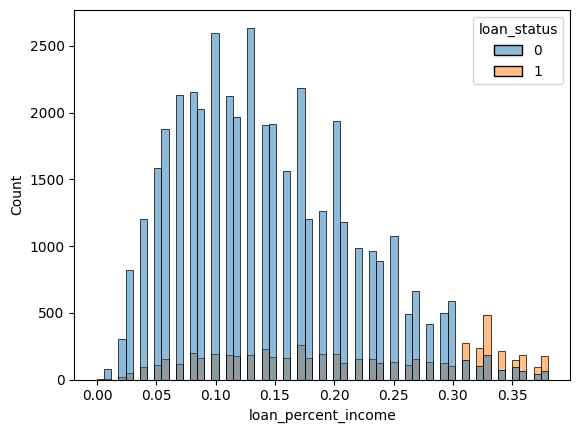

In [36]:

sns.histplot(x='loan_percent_income',hue='loan_status',data=df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='cb_person_cred_hist_length', ylabel='Count'>

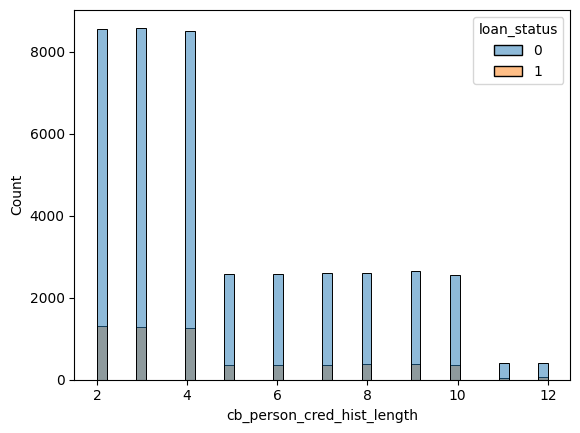

In [37]:

sns.histplot(x='cb_person_cred_hist_length',hue='loan_status',data=df)

<Axes: >

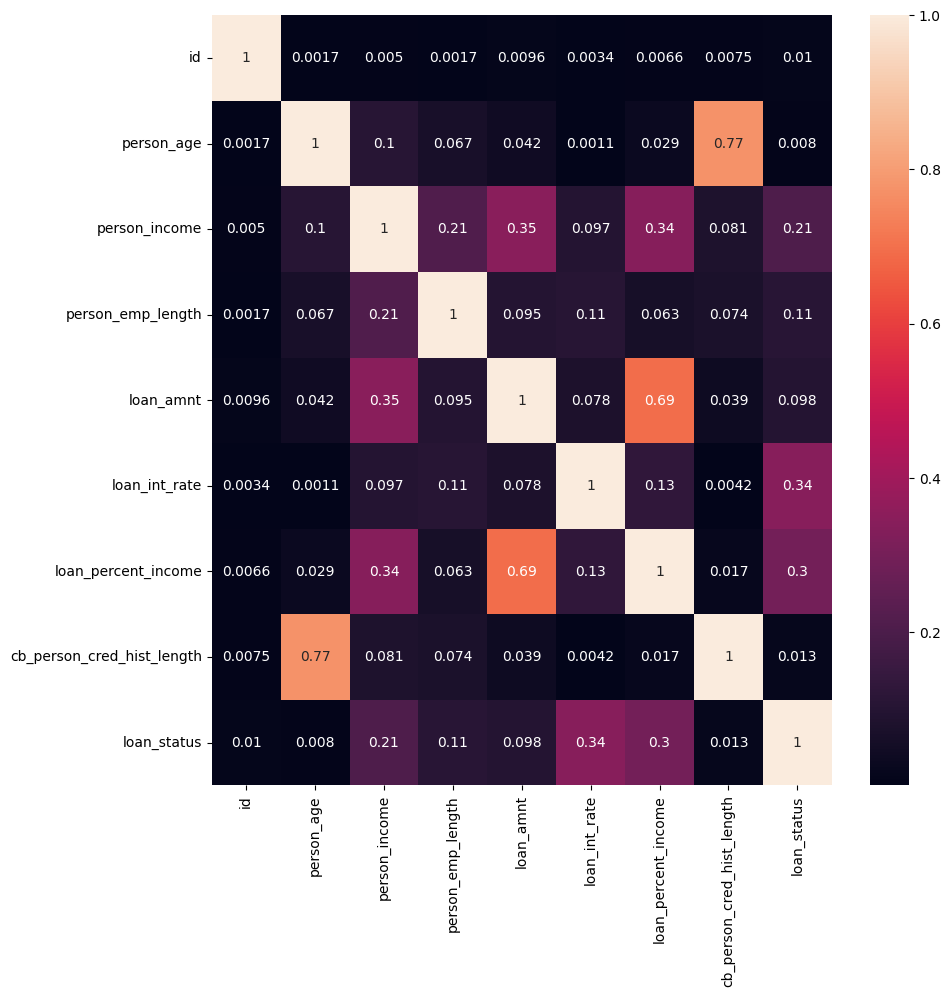

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(df[numerical].corr().abs(),annot=True)

## Loan Amount and Loan Int Rate are correlated ( 69%)
## Person Age and cb_Person_cred_hist_length are also correlated (77%)

In [39]:
categorical

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

<Axes: xlabel='loan_intent'>

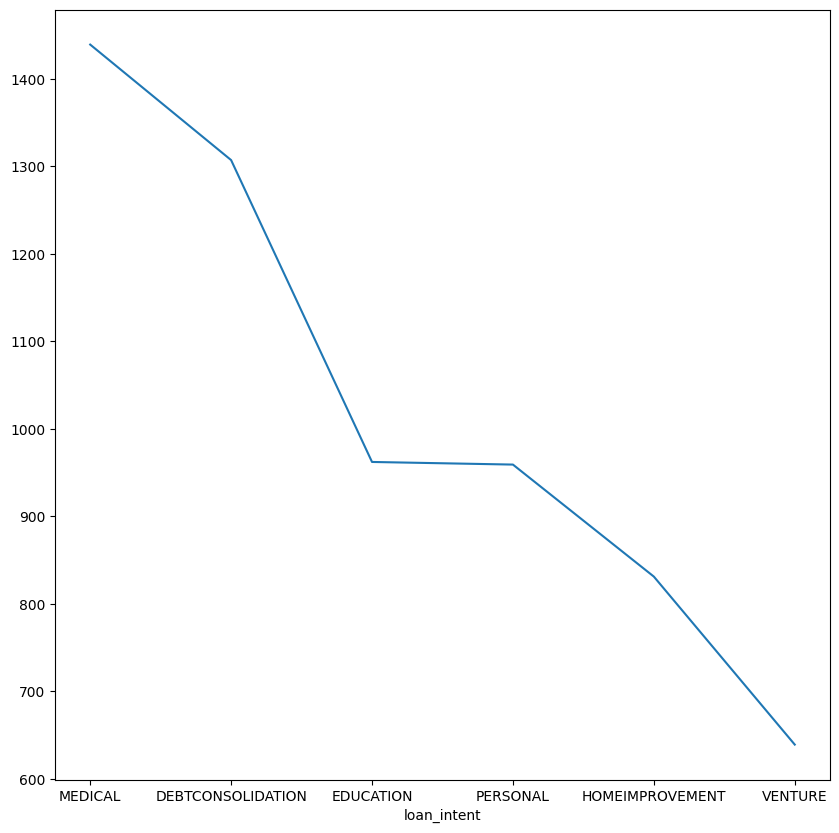

In [40]:
## Loan Approved  based on Loan Intent
df[df.loan_status==1].loan_intent.value_counts().plot(figsize=(10,10))

<Axes: xlabel='loan_intent'>

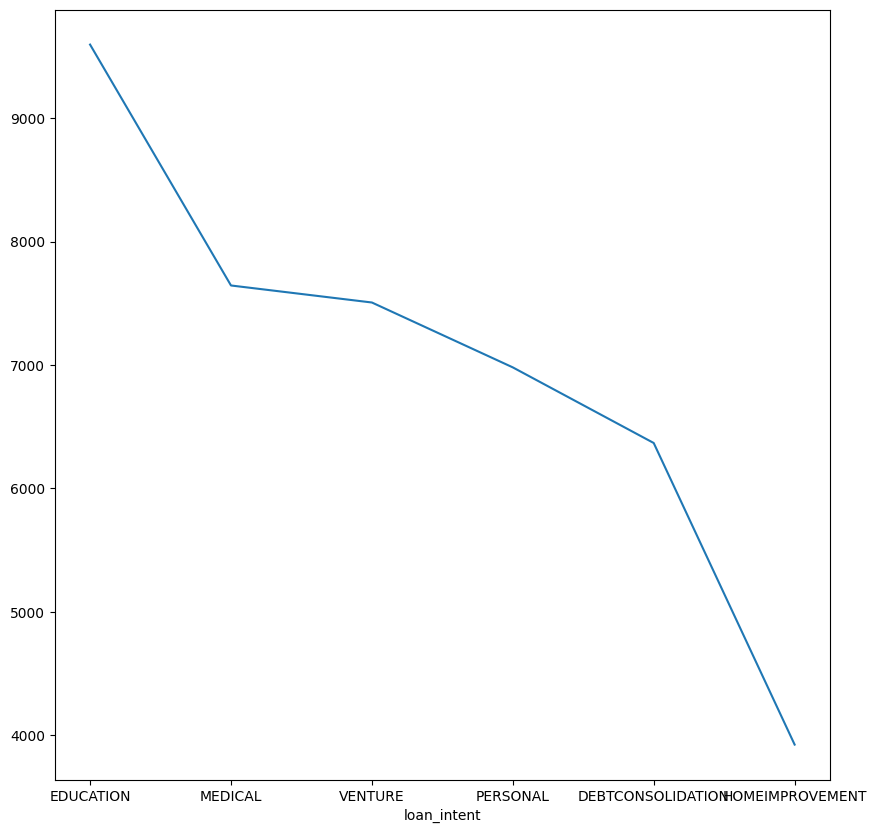

In [41]:
## Loan Denied  based on Loan Intent
df[df.loan_status==0].loan_intent.value_counts().plot(figsize=(10,10))


<Axes: xlabel='cb_person_default_on_file'>

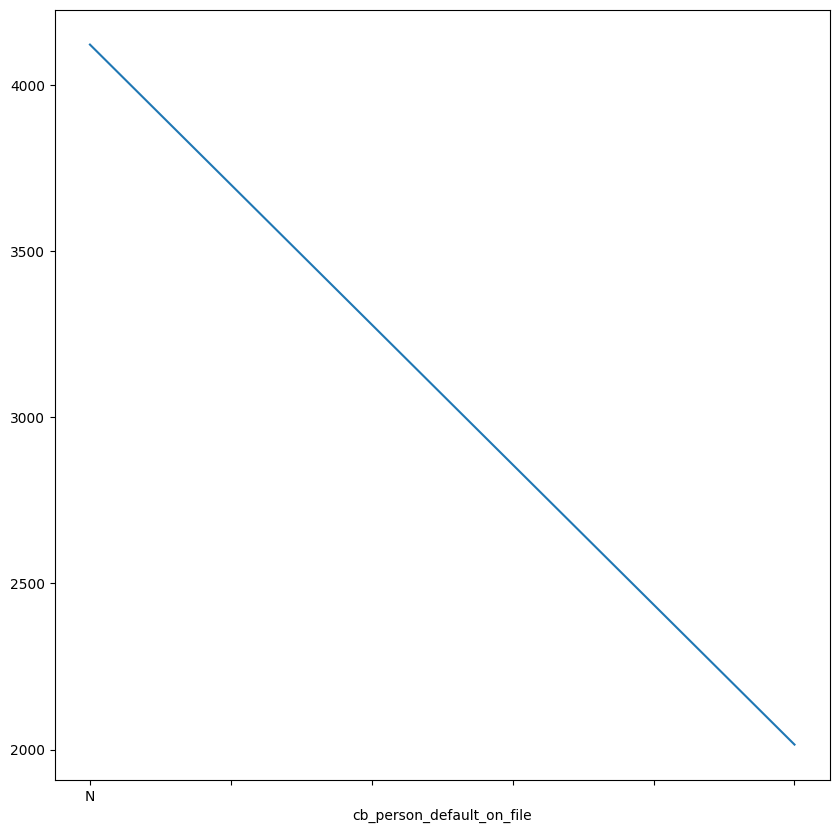

In [42]:
df[df.loan_status==1].cb_person_default_on_file.value_counts().plot(figsize=(10,10))

<Axes: xlabel='cb_person_default_on_file'>

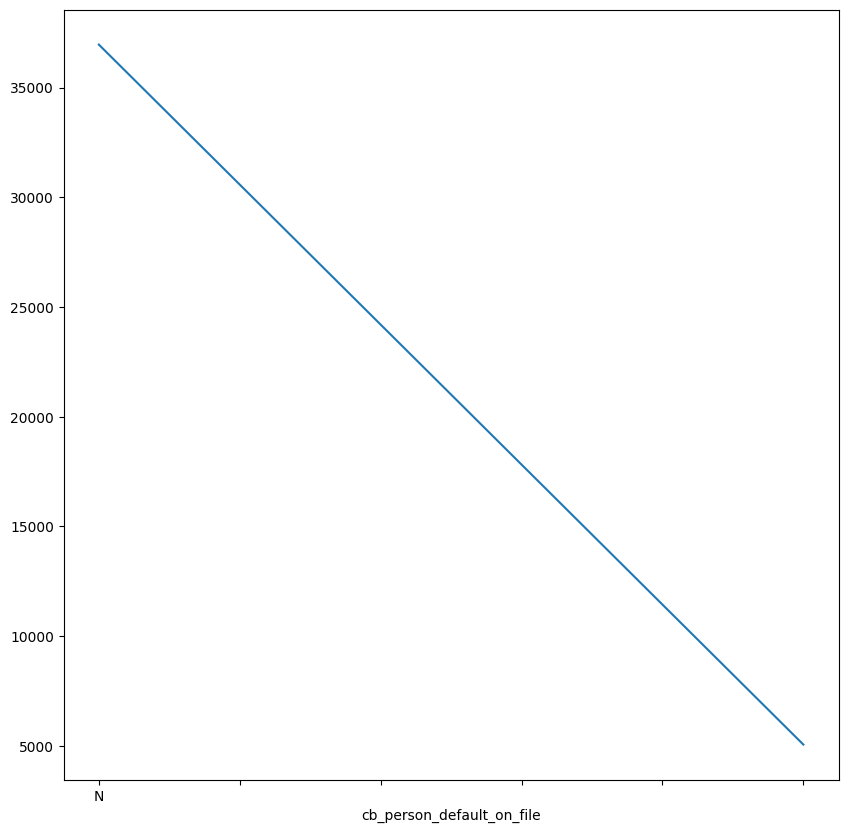

In [43]:
df[df.loan_status==0].cb_person_default_on_file.value_counts().plot(figsize=(10,10))

In [44]:
df.cb_person_default_on_file.value_counts()

cb_person_default_on_file
N    41080
Y     7073
Name: count, dtype: int64

In [45]:
df[df.loan_status==0].cb_person_default_on_file.value_counts()

cb_person_default_on_file
N    36958
Y     5058
Name: count, dtype: int64

In [46]:
df[df.loan_status==1].cb_person_default_on_file.value_counts()

cb_person_default_on_file
N    4122
Y    2015
Name: count, dtype: int64

<Axes: xlabel='person_home_ownership'>

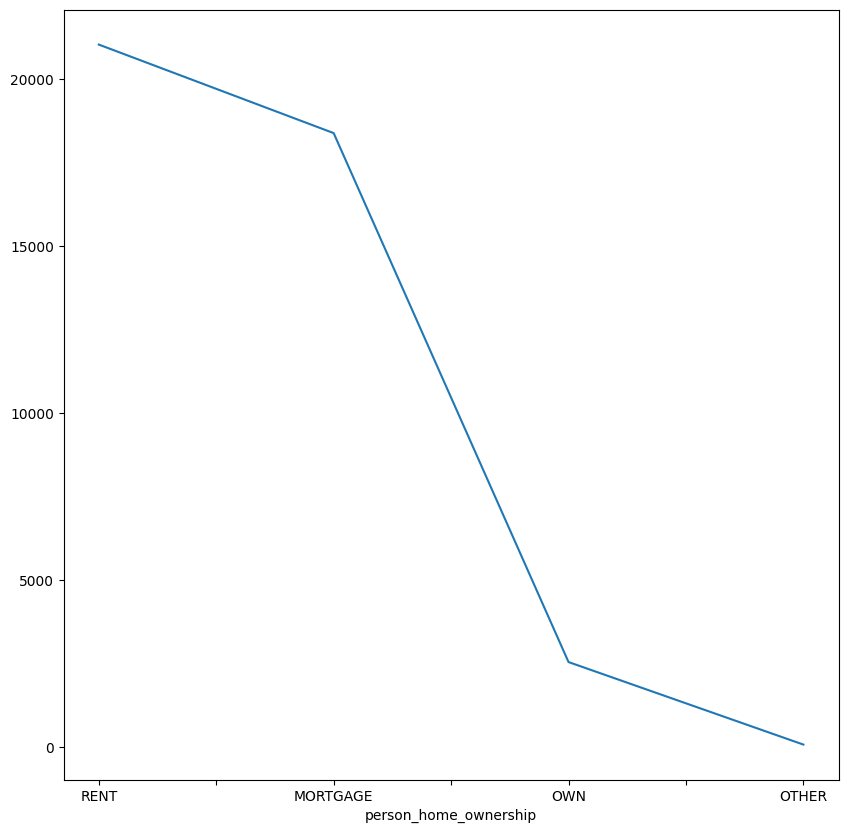

In [47]:
df[df.loan_status==0].person_home_ownership.value_counts().plot(figsize=(10,10))


<Axes: xlabel='person_home_ownership'>

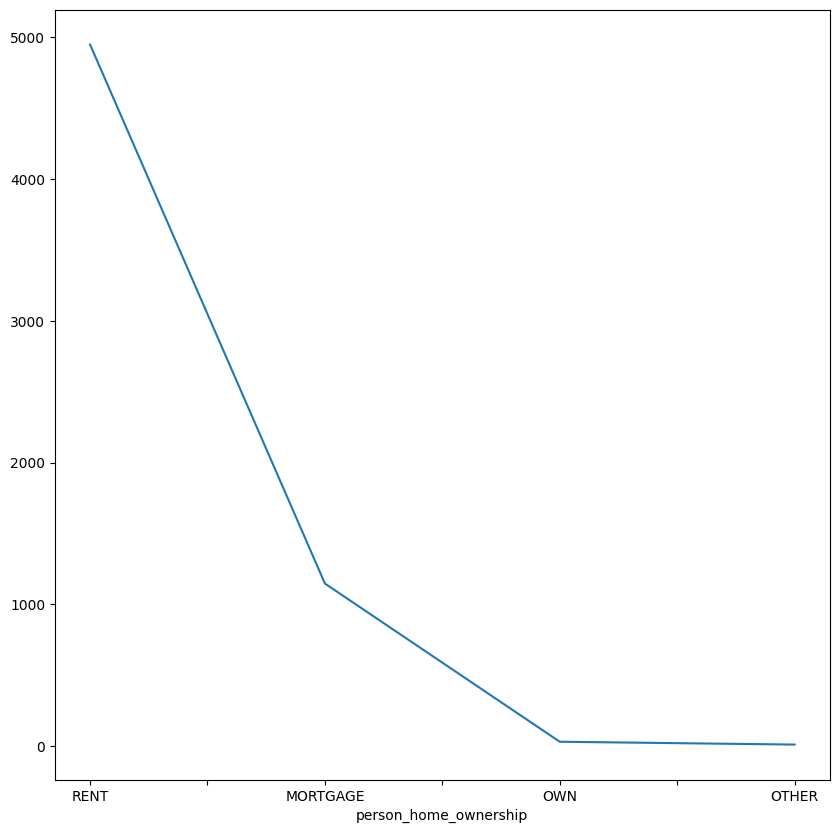

In [48]:
df[df.loan_status==1].person_home_ownership.value_counts().plot(figsize=(10,10))


## The above feature person_home_ownership doesn't impact the probability of loan denial/ approval
 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='loan_int_rate', ylabel='Count'>

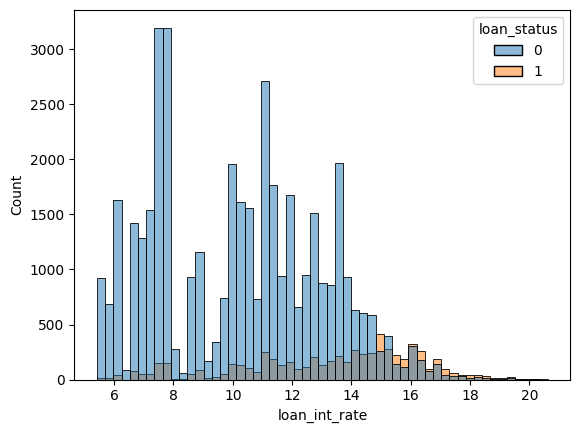

In [49]:
sns.histplot(x='loan_int_rate',hue='loan_status',data=df)

In [50]:
df.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [51]:
X=['person_income','loan_int_rate','loan_percent_income','cb_person_default_on_file','loan_intent']
Y='loan_status'

In [52]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(df[X],df[Y],test_size=0.25)

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

transfomer = ColumnTransformer(
[("encoder",OneHotEncoder(),['cb_person_default_on_file','loan_intent']),
("scaler",StandardScaler(),['loan_percent_income','loan_int_rate','person_income',])],
remainder='passthrough')

In [54]:
X_train_transformed = transfomer.fit_transform(X_train)


In [55]:
X_test_transformed = transfomer.transform(X_test)

In [56]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from catboost import CatBoostClassifier

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

models={
    "RandomForest":RandomForestClassifier(),
    "GradientBoost":GradientBoostingClassifier(),
    "DecisionTree":DecisionTreeClassifier(),
    "XGBoost":xgb.XGBClassifier(),
   
}

In [57]:
metrics={}
names=[]
train_accuracy=[]
test_accuracy=[]
roc_score=[]
from sklearn.metrics import roc_auc_score
for name,model in models.items():
    model.fit(X_train_transformed,Y_train)
    names.append(name)
    train_accuracy.append(model.score(X_train_transformed,Y_train))
    test_accuracy.append(model.score(X_test_transformed,Y_test))
    y_pred = model.predict(X_test_transformed)
    roc_score.append(roc_auc_score(Y_test,y_pred))
    
result=pd.DataFrame()
result['Model']=names
result['Training Score']=train_accuracy
result['Test Accuracy']=test_accuracy


    

In [58]:
result

,Model,Training Score,Test Accuracy
0,RandomForest,0.997646,0.917352
1,GradientBoost,0.926815,0.928316
2,DecisionTree,0.997757,0.894510
3,XGBoost,0.948524,0.931473


In [59]:
model =xgb.XGBClassifier()
model.fit(X_train_transformed,Y_train)
y_pred = model.predict(X_test_transformed)